# Ungraded Lab: Feature Engineering with Weather Data

In this 1st exercise on feature engineering with time series data, you will practice data transformation with the [Weather Dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/). You will be using [tf.Transform](https://www.tensorflow.org/tfx/transform/get_started) here instead of TFX because, as of this version (1.4), it is more straightforward to preserve the sequence of your records using this framework. If you remember, TFX by default always shuffles the data when ingesting through the `ExampleGen` component and that is not ideal when preparing data for forecasting applications.

This dataset has 10-minute intervals of 14 different features such as air temperature, atmospheric pressure, and humidity. For this lab, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book *Deep Learning with Python*.

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

You will perform data preprocessing so that the features can be used to train an LSTM using TensorFlow and Keras downstream. You will not be asked to train a model as the focus is on feature preprocessing.

Upon completion, you will have

* Explored and visualized the weather time series dataset and declared its schema
* Transformed the data for modeling using [tf.Transform](https://www.tensorflow.org/tfx/transform/get_started)
* Prepared training dataset windows from the output of `tf.Transform`

## Install Packages

First, you will install the `tensorflow_transform` Python package and its dependencies. This includes other modules you will need such as [`apache_beam`](https://beam.apache.org/) for data processing, and [`tfx_bsl`](https://github.com/tensorflow/tfx-bsl) which has utilities for working with Tensorflow data representations.


In [ ]:
!pip install tensorflow_transform==1.4.0

     |████████████████████████████████| 413 kB 6.4 MB/s 
     |████████████████████████████████| 14.8 MB 39.4 MB/s 
     |████████████████████████████████| 463.8 MB 32 kB/s 
     |████████████████████████████████| 129 kB 58.8 MB/s 
     |████████████████████████████████| 23.6 MB 1.3 MB/s 
     |████████████████████████████████| 19.1 MB 646 kB/s 
     |████████████████████████████████| 10.2 MB 41.6 MB/s 
     |████████████████████████████████| 48 kB 4.8 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 508 kB 51.5 MB/s 
     |████████████████████████████████| 253 kB 60.2 MB/s 
     |████████████████████████████████| 151 kB 54.6 MB/s 
     |████████████████████████████████| 2.3 MB 40.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 173 kB 58.6 MB/s 
     |████████████████████████████████| 267 kB 63.7 MB/s 
     |████████████████████████████████| 183 kB 69.8 MB/s 
     |█████████████

*Note: In Google Colab, you need to restart the runtime at this point to finalize updating the packages you just installed. You can do so by clicking the `Restart Runtime` at the end of the output cell above (after installation), or by selecting `Runtime > Restart Runtime` in the Menu bar. **Please do not proceed to the next section without restarting.** You can also ignore the errors about version incompatibility of some of the bundled packages because we won't be using those in this notebook.*

## Imports

Running the imports below should not show any error. Otherwise, please restart your runtime or re-run the package installation cell above.

In [ ]:
import apache_beam as beam
print('Apache Beam version: {}'.format(beam.__version__))

import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))

import tensorflow_transform as tft
from tensorflow_transform import beam as tft_beam
from tensorflow_transform.tf_metadata import dataset_metadata
from tensorflow_transform.tf_metadata import schema_utils
print('TensorFlow Transform version: {}'.format(tft.__version__))

Apache Beam version: 2.38.0
Tensorflow version: 2.6.3
TensorFlow Transform version: 1.4.0


## Download the Data

Next, you will download the data and put it in your workspace.

In [ ]:
import os

# Directory of the raw data files
DATA_DIR = '/content/data/'

# Download the dataset
!wget -nc https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv -P {DATA_DIR}

# Assign data path to a variable for easy reference
INPUT_FILE = os.path.join(DATA_DIR, 'jena_climate_2009_2016.csv')

--2022-05-04 16:12:27--  https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43164220 (41M) [text/plain]
Saving to: ‘/content/data/jena_climate_2009_2016.csv’

jena_climate_2009_2 100%[===================>]  41.16M   163MB/s    in 0.3s    

2022-05-04 16:12:28 (163 MB/s) - ‘/content/data/jena_climate_2009_2016.csv’ saved [43164220/43164220]



You can now preview the dataset.

In [ ]:
import pandas as pd

# Put dataset in a dataframe
df = pd.read_csv(INPUT_FILE, header=0, index_col=0)

# Preview the last few rows
df.tail()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


As you can see above, an observation is recorded every 10 minutes. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

##Inspect the Data

You can then inspect the data to see if there are any issues that you need to address before feeding it to your model. First, you will generate some descriptive statistics using the [`describe()`](https://www.geeksforgeeks.org/python-pandas-dataframe-describe-method/) method of the dataframe.



In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


You can see that the min value for `wv (m/s)` and `max. wv(m/s)` is `-9999.0`. Those are pretty intense winds and based on the other data points, these just look like faulty measurements. This is more pronounced when you visualize the data using the utilities below.

In [ ]:
# Define feature keys

TIMESTAMP_FEATURES = ["Date Time"]
NUMERIC_FEATURES = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)", 
    "rh (%)", 
    "VPmax (mbar)", 
    "VPact (mbar)", 
    "VPdef (mbar)", 
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

In [ ]:
#@ title Visualization Utilities
import matplotlib.pyplot as plt

# Color Palette
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

# Plots each column as a time series
def visualize_plots(dataset, columns):
    features = dataset[columns]
    fig, axes = plt.subplots(
        nrows=len(columns)//2 + len(columns)%2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i, col in enumerate(columns):
        c = colors[i % (len(colors))]
        t_data = dataset[col]
        t_data.index = dataset.index
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(col),
            rot=25,
        )
    ax.legend([col])
    plt.tight_layout()

In [ ]:
# Visualize the dataset
visualize_plots(df, NUMERIC_FEATURES)

As you can see, there's a very big downward spike towards `-9999` for the two features mentioned. You may know of different methods in handling outliers but for simplicity in this exercise, you will just set these to `0`. You can visualize the plots again after making this change.

In [ ]:
# Set the wind velocity outliers to 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

# Set the max wind velocity outliers to 0
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

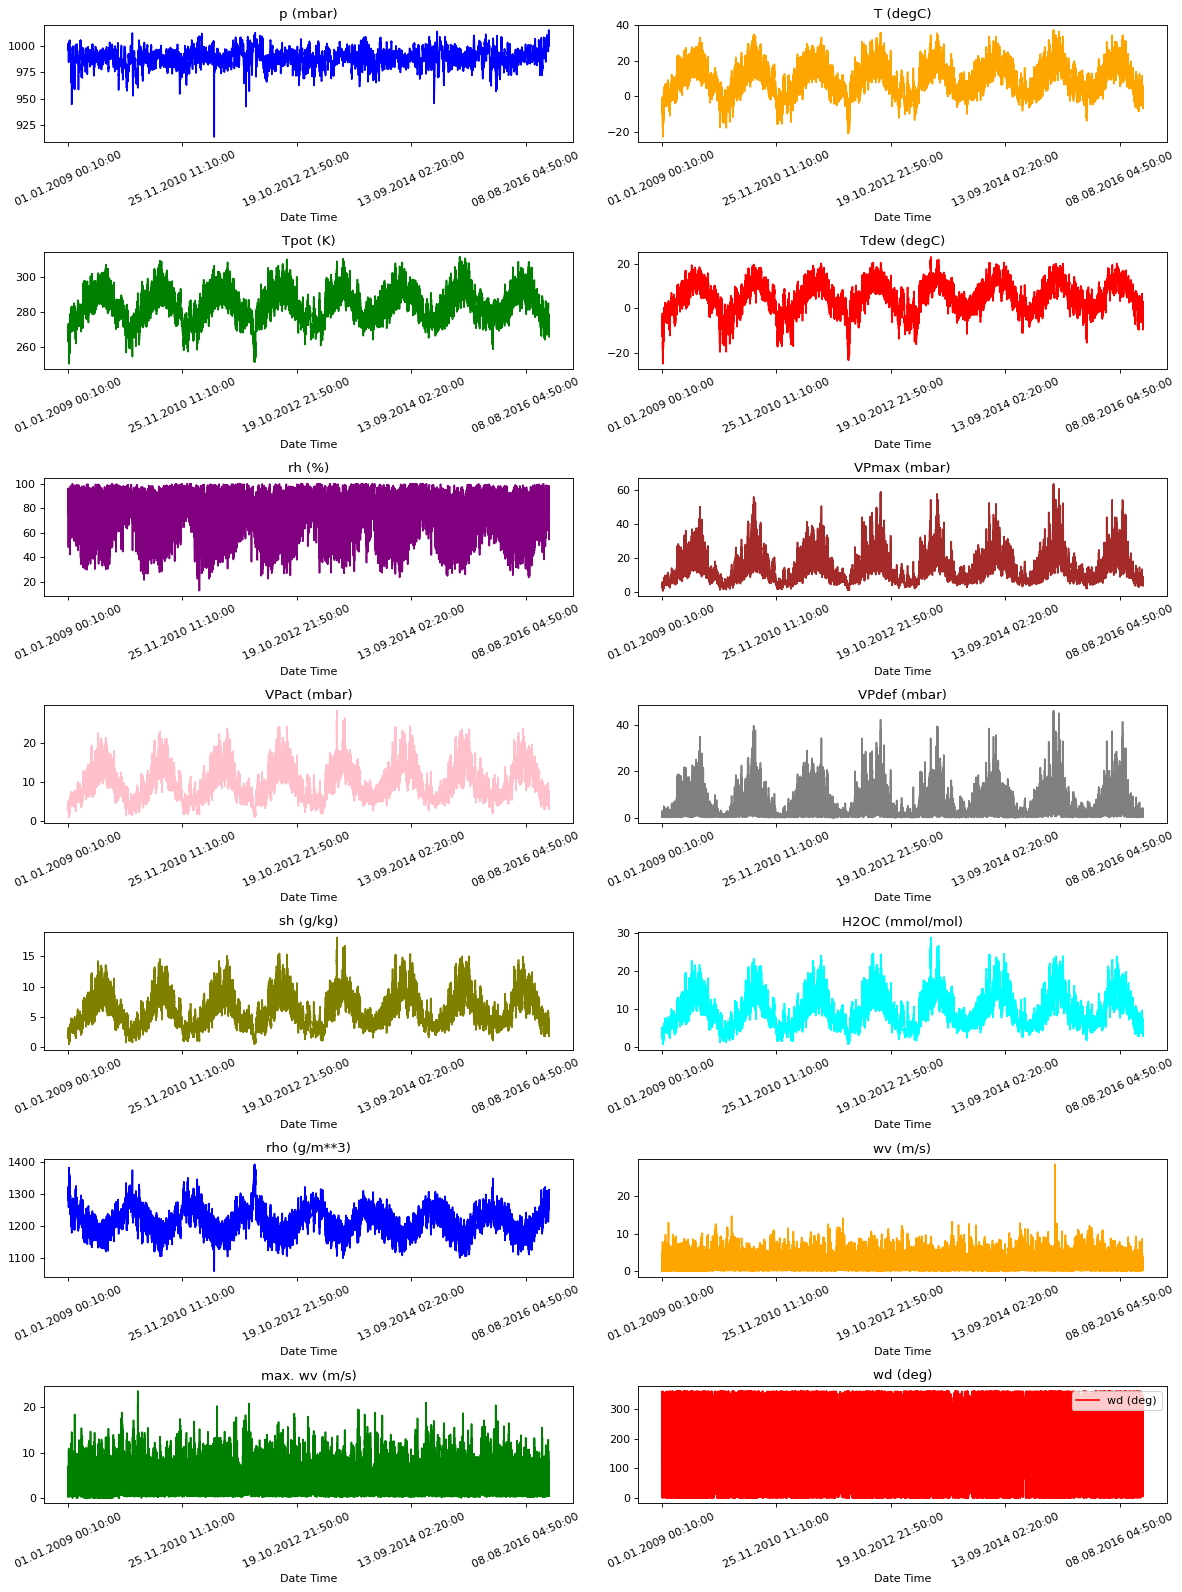

In [ ]:
visualize_plots(df, NUMERIC_FEATURES)

Take note that you are just visualizing the Pandas dataframe here. You will do this simple data cleaning again later when Tensorflow Transform consumes the raw CSV file.

## Feature Engineering

Now you will be doing feature engineering. There are several things to note before doing the transformation:



### Correlated features

You may want to drop redundant features to reduce the complexity of your model. Let's see what features are highly correlated with each other by plotting the correlation matrix.

In [ ]:
import seaborn as sns

def show_correlation_heatmap(dataframe):
    plt.figure(figsize=(20,20))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
    plt.show()

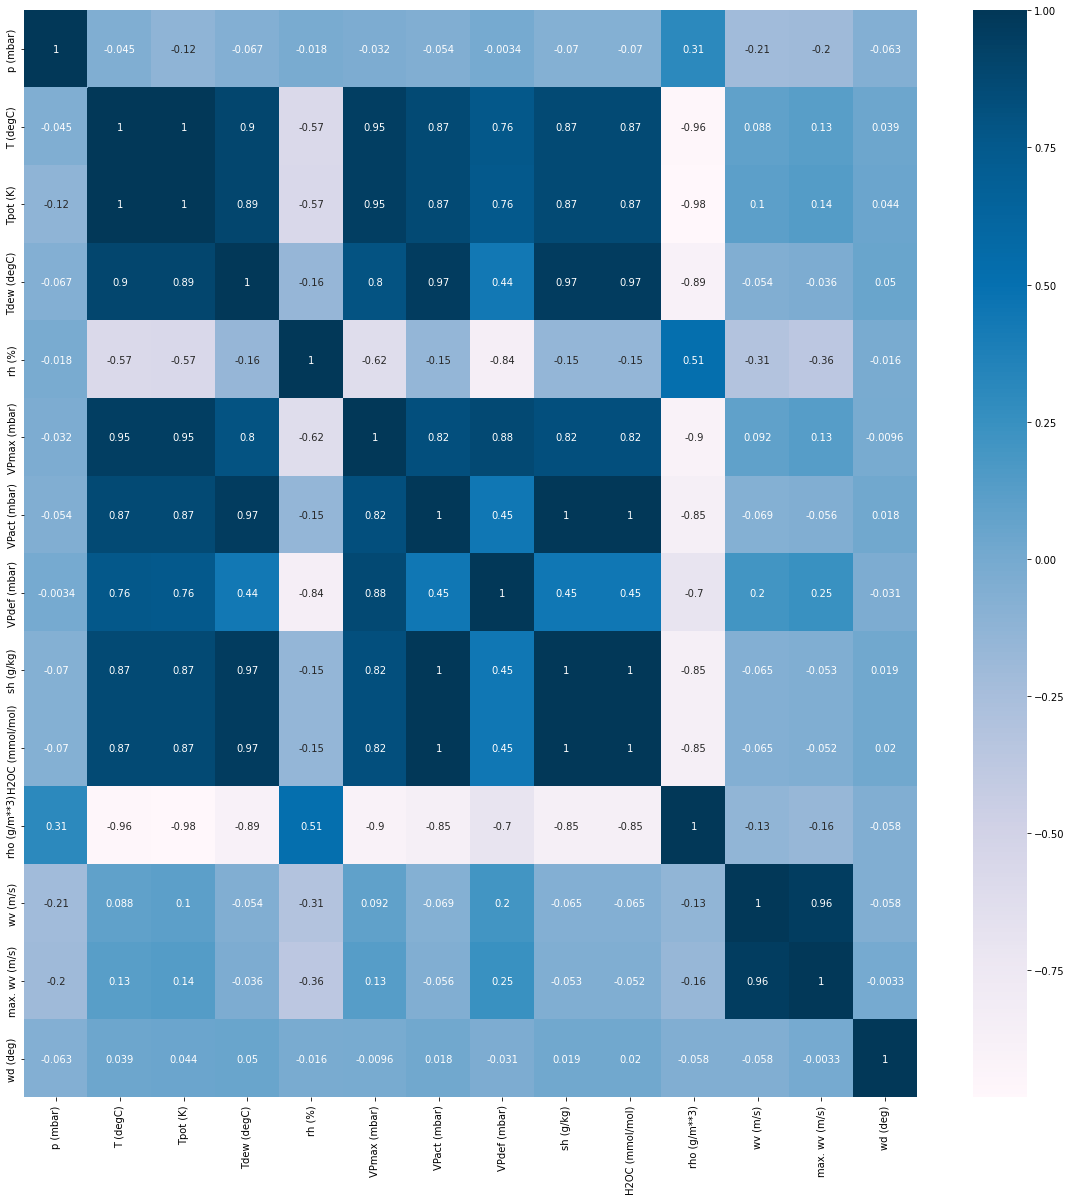

In [ ]:
show_correlation_heatmap(df)

You can observe that `Tpot (K)`, `Tdew (degC)`, `VPmax(mbar)`, `Vpact(mbar)`, `VPdef (mbar)`, `sh(g/kg)` and `H2OC` are highly positively correlated to the target `T (degC)`. Likewise, `rho` is highly negatively correlated to the target. 

In the features that are positively correlated, you can see that `VPmax (mbar)` is highly correlated to some features like `Vpact (mbar)`, `Tdew (degC)` and `Tpot (K)`. Hence, for the sake of this exercise you can drop these features and retain `VPmax (mbar)`.

In [ ]:
# Features to filter out
FEATURES_TO_REMOVE = ["Tpot (K)", "Tdew (degC)","VPact (mbar)" , "H2OC (mmol/mol)", "max. wv (m/s)"]

### Distribution of Wind Data

The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. However, angles in this current format do not make good model inputs. 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. This will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector. Observe how sine and cosine are used to generate wind vector features (`Wx` and `Wy`) in the `preprocessing_fn()` later.




### Date Time Feature

Dealing with weather, you can expect patterns depending on when the measurements are made. For example, temperatures are generally colder at night and wind velocities might be higher during typhoon season. Thus, the `Date Time` column is a good input to your model to take daily and yearly periodicity into account. 

To do this, you will first use the [datetime](https://docs.python.org/3/library/datetime.htm) Python module to convert the current date time string format (i.e. _day.month.year hour:minute:second_) to a timestamp with units in seconds. Then, a simple approach to generate a periodic signal is to again use sine and cosine to convert the timestamp to clear "Time of day" (`Day sin`, `Day cos`) and "Time of year" (`Year sin`, `Year cos`) signals. You will see these conversions in the `clean_fn()` and `preprocessing_fn()`. 

You can see the `clean_fn()` utility function below that removes wind velocity outliers and converts the date time string to a [Unix timestamp](https://www.unixtimestamp.com/).

In [ ]:
from datetime import datetime

# combine features into one list
ordered_columns = TIMESTAMP_FEATURES + NUMERIC_FEATURES

# index of the date time string
date_time_idx = ordered_columns.index(TIMESTAMP_FEATURES[0])

# index of the 'wv (m/s)' feature
wv_idx = ordered_columns.index('wv (m/s)')

def clean_fn(line):
  '''
  Converts datetime strings in the CSV to Unix timestamps and removes outliers
  the wind velocity column. Used as part of
  the transform pipeline.

  Args:
    line (string) - one row of a CSV file
  
  Returns:

  '''

  # Split the CSV string to a list
  line_split = line.split(b',')

  # Decodes the timestamp string to utf-8
  date_time_string = line_split[date_time_idx].decode("utf-8")

  # Creates a datetime object from the timestamp string
  date_time = datetime.strptime(date_time_string, '%d.%m.%Y %H:%M:%S')

  # Generates a timestamp from the object
  timestamp = datetime.timestamp(date_time)

  # Overwrites the string timestamp in the row with the timestamp in seconds
  line_split[date_time_idx] = bytes(str(timestamp), 'utf-8')

  # Check if wind velocity is an outlier
  if line_split[wv_idx] == b'-9999.0':

    # Overwrite with default value of 0
    line_split[wv_idx] = b'0.0'

  # rejoin the list item into one string
  mod_line = b','.join(line_split)

  return mod_line

### Create a `tf.Transform` preprocessing_fn

With the considerations above, you can now declare your `preprocessing_fn()`. This will be used by Tensorflow Transform to create a transformation graph that will preprocess model inputs. In a nutshell, your preprocessing function will perform the following steps:

1. Perform feature selection by deleting the unwanted features. 
2. Transform wind direction and velocity columns into a wind vector.
3. Convert date in timestamp to a usable signal by using `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals. 
4. Normalize the float features.


In [ ]:
import numpy as np
import math as m

def preprocessing_fn(inputs):
  """Preprocess input columns into transformed columns."""
  
  outputs = inputs.copy()

  # Filter redundant features
  for key in FEATURES_TO_REMOVE:
    del outputs[key]

  # Convert degrees to radians
  pi = tf.constant(m.pi)
  wd_rad = inputs['wd (deg)'] * pi / 180.0

  # Calculate the wind x and y components.
  outputs['Wx'] = inputs['wv (m/s)'] * tf.math.cos(wd_rad)
  outputs['Wy'] = inputs['wv (m/s)'] * tf.math.sin(wd_rad)

  # Delete `wv (m/s)` and `wd (deg)` after getting the wind vector
  del outputs['wv (m/s)']
  del outputs['wd (deg)']

  # Get day and year in seconds
  day = tf.cast(24*60*60, tf.float32)
  year = tf.cast((365.2425)*day, tf.float32)

  # Get timestamp feature
  timestamp_s = outputs['Date Time']

  # Convert timestamps into periodic signals
  outputs['Day sin'] = tf.math.sin(timestamp_s * (2 * pi / day))
  outputs['Day cos'] = tf.math.cos(timestamp_s * (2 * pi / day))
  outputs['Year sin'] = tf.math.sin(timestamp_s * (2 * pi / year))
  outputs['Year cos'] = tf.math.cos(timestamp_s * (2 * pi / year))

  # Delete timestamp feature
  del outputs['Date Time']

  # Declare final list of features
  FINAL_FEATURE_LIST =  ["p (mbar)",
    "T (degC)",
    "rh (%)", 
    "VPmax (mbar)", 
    "VPdef (mbar)", 
    "sh (g/kg)",
    "rho (g/m**3)",
    "Wx",
    "Wy",
    "Day sin",
    'Day cos',
    'Year sin',
    'Year cos'
    ]

  # Scale all features
  for key in FINAL_FEATURE_LIST:
    outputs[key] = tft.scale_to_0_1(outputs[key])

  return outputs

## Transform the data

You're almost ready to start transforming the data in an Apache Beam pipeline. Before doing so, you will declare just a few more utility functions and variables.

### Train Test Split

First, you will define how your dataset will be split. You will use the first 300,000 observations for training and the rest for testing.

You will extract the date time object of the 300,000th observation to use it in partitioning the dataset using [`Beam.Partition()`](https://beam.apache.org/documentation/transforms/python/elementwise/partition/). This method expects a `partition_fn()` that returns an integer indicating the partition number. Since you will only need two (i.e. train and test), you will make the function return `0` when it is part of the train split, and `1` for the test. See how this is implemented in the cell below.

In [ ]:
# Number of records to include in the train split
TRAIN_SPLIT = 300000

# Get date time of the last element in the train split
date_time_train_boundary = df.iloc[TRAIN_SPLIT - 1].name

# Creates a datetime object from the timestamp string
date_time_train_boundary = datetime.strptime(date_time_train_boundary, '%d.%m.%Y %H:%M:%S')

# Convert date time string to Unix timestamp in seconds
date_time_train_boundary = bytes(str(datetime.timestamp(date_time_train_boundary)), 'utf-8')


def partition_fn(line, num_partitions):
  '''
  Partition function to work with Beam.partition

  Args:
    line (string) - One record in the CSV file.
    num_partition (integer) - Number of partitions. Required argument by Beam. Unused in this function.

  Returns:
    0 or 1 (integer) - 0 if line timestamp is below the date time boundary, 1 otherwise. 
  '''

  # Split the CSV string to a list
  line_split = line.split(b',')

  # Get the timestamp of the current line
  line_dt = line_split[date_time_idx]

  # Check if it is above or below the date time boundary
  partition_num = int(line_dt > date_time_train_boundary)

  return partition_num

### Declare Schema for Cleaned Data

Just like in the previous labs with TFX, you will want to declare a schema to make sure that your data input is parsed correctly. You can do that with the cell below. Take note that this will be used later after the data cleaning step. Thus, you can expect that the date time feature is now in seconds and assigned to be a float feature.

In [ ]:
# Declare feature spec
RAW_DATA_FEATURE_SPEC = dict(
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in TIMESTAMP_FEATURES] +
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in NUMERIC_FEATURES]
)

# Create schema from feature spec
RAW_DATA_SCHEMA = tft.tf_metadata.schema_utils.schema_from_feature_spec(RAW_DATA_FEATURE_SPEC)

### Create the `tf.Transform` pipeline

Now you can define the TF Transform pipeline. It will follow these major steps:

1. Read in the data using the CSV reader
1. Remove outliers and reformat timestamps using the `clean_fn`.
1. Partition the dataset into train and test splits using the `beam.Partition` transform.
1. Preprocess the data splits using the `preprocessing_fn`.
1. Write the result as a `TFRecord` of `Example` protos.

In [ ]:
import shutil
from tfx_bsl.coders.example_coder import RecordBatchToExamplesEncoder
from tfx_bsl.public import tfxio

# Directory names for the TF Transform outputs
WORKING_DIR = 'transform_dir'
TRANSFORM_TRAIN_FILENAME = 'transform_train'
TRANSFORM_TEST_FILENAME = 'transform_test'
TRANSFORM_TEMP_DIR = 'tft_temp'


# The "with" block will create a pipeline, and run that pipeline at the exit
#   of the block.
def read_and_transform_data(working_dir):
  '''
  Reads a CSV File and preprocesses the data using TF Transform

  Args:
    working_dir (string) - directory to place TF Transform outputs
  
  Returns:
    transform_fn - transformation graph
    transformed_train_data - transformed training examples
    transformed_test_data - transformed test examples
    transformed_metadata - transform output metadata
  '''

  # Delete TF Transform if it already exists
  if os.path.exists(working_dir):
    shutil.rmtree(working_dir)

  with beam.Pipeline() as pipeline:
      with tft_beam.Context(temp_dir=os.path.join(working_dir, TRANSFORM_TEMP_DIR)):
        
        # Read the input CSV and clean the data
        raw_data = (
              pipeline
              | 'ReadTrainData' >> beam.io.ReadFromText(INPUT_FILE, coder=beam.coders.BytesCoder(), skip_header_lines=1)
              | 'CleanLines' >> beam.Map(clean_fn))

        # Partition the dataset into train and test sets using the partition_fn defined earlier.    
        raw_train_data, raw_test_data = (raw_data
                                 | 'TrainTestSplit' >> beam.Partition(partition_fn, 2))
        
        # Create a TFXIO to read the data with the schema. You need
        # to list all columns in order since the schema doesn't specify the
        # order of columns in the csv.
        csv_tfxio = tfxio.BeamRecordCsvTFXIO(
              physical_format='text',
              column_names=ordered_columns,
              schema=RAW_DATA_SCHEMA)

        # Parse the raw train data into inputs for TF Transform
        raw_train_data = (raw_train_data 
                          | 'DecodeTrainData' >> csv_tfxio.BeamSource())
        
        # Get the raw data metadata
        RAW_DATA_METADATA = csv_tfxio.TensorAdapterConfig()
        
        # Pair the train data with the metadata into a tuple
        raw_train_dataset = (raw_train_data, RAW_DATA_METADATA)

        # Training data transformation. The TFXIO (RecordBatch) output format
        # is chosen for improved performance.
        (transformed_train_data,transformed_metadata) , transform_fn = (
        raw_train_dataset | tft_beam.AnalyzeAndTransformDataset(preprocessing_fn, output_record_batches=True))


        # Parse the raw data into inputs for TF Transform
        raw_test_data = (raw_test_data
                         | 'DecodeTestData' >> csv_tfxio.BeamSource())
        
        # Pair the test data with the metadata into a tuple
        raw_test_dataset = (raw_test_data, RAW_DATA_METADATA)
        
        # Now apply the same transform function to the test data.
        # You don't need the transformed data schema. It's the same as before.
        transformed_test_data, _ = (
          (raw_test_dataset, transform_fn) | tft_beam.TransformDataset(output_record_batches=True))
        
        # Declare an encoder to convert output record batches to TF Examples 
        transformed_data_coder = RecordBatchToExamplesEncoder(transformed_metadata.schema)
        
        # Encode transformed train data and write to disk
        _ = (
            transformed_train_data
            | 'EncodeTrainData' >> beam.FlatMapTuple(lambda batch, _: transformed_data_coder.encode(batch))
            | 'WriteTrainData' >> beam.io.WriteToTFRecord(
                os.path.join(working_dir, TRANSFORM_TRAIN_FILENAME)))

        # Encode transformed test data and write to disk
        _ = (
            transformed_test_data
            | 'EncodeTestData' >> beam.FlatMapTuple(lambda batch, _: transformed_data_coder.encode(batch))
            | 'WriteTestData' >> beam.io.WriteToTFRecord(
                os.path.join(working_dir, TRANSFORM_TEST_FILENAME)))
        
        # Write transform function to disk
        _ = (
          transform_fn
          | 'WriteTransformFn' >>
          tft_beam.WriteTransformFn(os.path.join(working_dir)))

         
  return transform_fn, transformed_train_data, transformed_test_data, transformed_metadata

In [ ]:
def main():
  return read_and_transform_data(WORKING_DIR)

if __name__ == '__main__':
  transform_fn, transformed_train_data, trainsformed_test_data, transformed_metadata = main()

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


INFO:tensorflow:Assets written to: transform_dir/tft_temp/tftransform_tmp/8e0027cad9df4bc78ea8e6575906184b/assets


INFO:tensorflow:Assets written to: transform_dir/tft_temp/tftransform_tmp/8e0027cad9df4bc78ea8e6575906184b/assets


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:Assets written to: transform_dir/tft_temp/tftransform_tmp/5e45b9181c664eadb2177f31a1bc13ce/assets


INFO:tensorflow:Assets written to: transform_dir/tft_temp/tftransform_tmp/5e45b9181c664eadb2177f31a1bc13ce/assets


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


##Prepare Training and Test Datasets from TFTransformOutput

Now that you have the transformed dataset, you will need to map it to training and test datasets whch can be used for training a model using TensorFlow. Since this is time series data, it makes sense to group a fixed-length series of measurements and map that to the label found in a future time step. For example, 3 days of data can be used to predict the next day's humidity. You can use the [tf.data.Dataset.window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method to implement these groupings.

In this exercise, you will use data from the last 5 days to predict the temperature 12 hours into the future. 

* You already know that data is taken every 10 minutes so there will be 720 data points for 5 days. 
* You will also assume that drastic change is not expected within an hour so you will downsample the 720 data points to 120 by just getting the data every hour. Thus, you will use a *stride* (or step size) of 6 when getting the data points. This makes the `HISTORY_SIZE` for the feature window equal to 120. 
* For this single step prediction model (forecasting), the label for a dataset window will be the temperature 12 hours into the future.
* By default, the `window()` method moves `size` (i.e. window size) steps at a time. For example, if you have a dataset with elements `[1, 2, 3, 4]` and you have `size=2`, then your results will look like: `[1, 2], [3, 4]`. You can reconfigure this behavior and move at smaller or larger steps with the `shift` parameter. For the same sample dataset with window `size=2` but with `shift=1`, the results will look like `[1, 2], [2,3], [3,4]` because the window is moving `1` element at a time.

In [ ]:
# Constants to prepare the transformed data for modeling

LABEL_KEY = 'T (degC)'
OBSERVATIONS_PER_HOUR = 6
HISTORY_SIZE = 120
FUTURE_TARGET = 12
BATCH_SIZE = 72
SHIFT = 1

In [ ]:
# Get the output of the Transform component
tf_transform_output = tft.TFTransformOutput(os.path.join(WORKING_DIR))

# Get the index of the label key
index_of_label = list(tf_transform_output.transformed_feature_spec().keys()).index(LABEL_KEY)
print(index_of_label)

2


Next, you will define several helper functions to extract the data from your transformed dataset and group it into windows. First, this `parse_function()` will help in getting the transformed features and rearranging them so that the label values (i.e. `T (degC)`) is at the end of the tensor.

In [ ]:
def parse_function(example_proto):
    
    feature_spec = tf_transform_output.transformed_feature_spec()
    
    # Define features with the example_proto (transformed data) and the feature_spec using tf.io.parse_single_example 
    features = tf.io.parse_single_example(example_proto, feature_spec)
    values = list(features.values())
    values[index_of_label], values[len(features) - 1] = values[len(features) - 1], values[index_of_label]
    
    # Stack the values along the first axis
    stacked_features = tf.stack(values, axis=0)

    return stacked_features


Next, you will separate the features and target values into a tuple with this utility function.

In [ ]:
def map_features_target(elements):
    features = elements[:HISTORY_SIZE]
    target = elements[-1:,-1]
    return (features, target)

Finally, you can define the dataset window with the function below. It uses the parameters defined above and also the helper functions to produce the batched feature-target mappings.

In [ ]:
def get_windowed_dataset(path):
        
    # Instantiate a tf.data.TFRecordDataset passing in the appropiate path
    dataset = tf.data.TFRecordDataset(path)
    
    # Use the dataset's map method to map the parse_function
    dataset = dataset.map(parse_function)
    
    # Use the window method with expected total size. Define stride and set drop_remainder to True
    dataset = dataset.window(HISTORY_SIZE + FUTURE_TARGET, shift=SHIFT, stride=OBSERVATIONS_PER_HOUR, drop_remainder=True)
    
    # Use the flat_map method passing in an anonymous function that given a window returns window.batch(HISTORY_SIZE + FUTURE_TARGET)
    dataset = dataset.flat_map(lambda window: window.batch(HISTORY_SIZE + FUTURE_TARGET))
    
    # Use the map method passing in the previously defined map_features_target function
    dataset = dataset.map(map_features_target) 
    
    # Use the batch method and pass in the appropiate batch size
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

You can now use the `get_dataset()` function on your transformed examples to produce the dataset windows.

In [ ]:
# Get list of train and test data tfrecord filenames from the transform outputs
train_tfrecord_files = tf.io.gfile.glob(os.path.join(WORKING_DIR, TRANSFORM_TRAIN_FILENAME + '*'))
test_tfrecord_files = tf.io.gfile.glob(os.path.join(WORKING_DIR, TRANSFORM_TEST_FILENAME + '*'))

# Generate dataset windows
windowed_train_dataset = get_windowed_dataset(train_tfrecord_files[0])
windowed_test_dataset = get_windowed_dataset(test_tfrecord_files[0])

Let's preview the resulting shapes of the data windows. If you print the shapes of the tensors in a single batch, you'll notice that it indeed produced the required dimensions. It has 72 examples per batch where each contain 120 measurements for each of the 13 features in the transformed dataset. The target tensor shape only has one feature per example in the batch as expected (i.e. only `T (degC)`).

In [ ]:
ordered_feature_spec_names = tf_transform_output.transformed_feature_spec().keys()

# Preview an example in the train dataset
for features, target  in windowed_train_dataset.take(1):
    print(f'Shape of input features for a batch: {features.shape}')
    print(f'Shape of targets for a batch: {target.shape}\n')

    print(f'INPUT FEATURES:')
    for value, name in zip(features[0][0].numpy(), ordered_feature_spec_names):
      print(f'{name} : {value}') 
  
    print(f'\nTARGET TEMPERATURE: {target[0][0]}')

Shape of input features for a batch: (72, 120, 13)
Shape of targets for a batch: (72, 1)

INPUT FEATURES:
Day cos : 0.9994063377380371
Day sin : 0.5243587493896484
T (degC) : 0.08167896419763565
VPdef (mbar) : 0.0052231717854738235
VPmax (mbar) : 0.04098501801490784
Wx : 0.5456575155258179
Wy : 0.5428817868232727
Year cos : 0.9999775886535645
Year sin : 0.5047342777252197
p (mbar) : 0.8355501890182495
rh (%) : 0.9230327606201172
rho (g/m**3) : 0.743212878704071
sh (g/kg) : 0.25462883710861206

TARGET TEMPERATURE: 0.14098861813545227


In [ ]:
# Preview an example in the test dataset
for features, target in windowed_test_dataset.take(1):
    print(f'Shape of input features for a batch: {features.shape}')
    print(f'Shape of targets for a batch: {target.shape}\n')

    print(f'INPUT FEATURES:')
    for value, name in zip(features[0][0].numpy(), ordered_feature_spec_names):
      print(f'{name} : {value}') 
  
    print(f'\nTARGET TEMPERATURE: {target[0][0]}')

Shape of input features for a batch: (72, 120, 13)
Shape of targets for a batch: (72, 1)

INPUT FEATURES:
Day cos : 0.9083542823791504
Day sin : 0.7885253429412842
T (degC) : 0.5666477680206299
VPdef (mbar) : 0.004748338367789984
VPmax (mbar) : 0.27363526821136475
Wx : 0.69806307554245
Wy : 0.5810309648513794
Year cos : 0.3435264229774475
Year sin : 0.025114715099334717
p (mbar) : 0.8016924262046814
rh (%) : 0.9862148761749268
rho (g/m**3) : 0.4026159942150116
sh (g/kg) : 0.6419228911399841

TARGET TEMPERATURE: 0.7635467648506165


## Wrap Up

In this notebook, you got to see how you may want to prepare seasonal data. It shows how you can handle periodicity and produce batches of dataset windows. You will be doing something similar in the next lab with sensor data. This time though, the measurements are taken at a much higher rate (20 Hz). The labels are also categorical so you will be handling that differently.

On to the next!